In [1]:
import glob, os
os.chdir("aclImdb/train/pos")

In [2]:
positive_sentences = []
for file in glob.glob("*.txt"):
    f = open(file, "r",encoding="utf8")
    content = (f.read())
    positive_sentences.append(content)


In [3]:
os.chdir("../neg")

In [4]:
negative_sentences=[]
for file in glob.glob("*.txt"):
    f = open(file, "r",encoding="utf8")
    content = (f.read())
    negative_sentences.append(content)

In [5]:
positive_sentences=[[x,1] for x in positive_sentences]
negative_sentences=[[x,0] for x in negative_sentences]
negative_sentences[:2]

[["Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.",
  0],
 ["Airport '77 starts as a brand new luxury 747 plane is loaded up with valuable paintings & such belonging to rich businessman Philip Stevens (James Stewart) who is flying them & a bunch of VIP's to his estate in preparation of it being opened to the public as a museum, also on board is Stevens daughter Julie (Kathleen Quinlan) & 

In [6]:
os.chdir("../../")

In [7]:
positive_sentences.extend(negative_sentences)


In [8]:
positive_sentences[:2]

[['Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!',
  1],
 ['Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everyt

In [9]:
sentences= [x[0] for x in positive_sentences]


In [10]:
label = [x[1] for x in positive_sentences]

In [11]:
import pandas as pd
import string
import nltk
import seaborn as sns
import re
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

In [12]:
len(sentences),len(label)

(25000, 25000)

In [13]:
df = pd.DataFrame({
    'text': sentences,
    'target': label,
})

In [14]:
df.head()

,text,target
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1


Text(0, 0.5, 'Count')

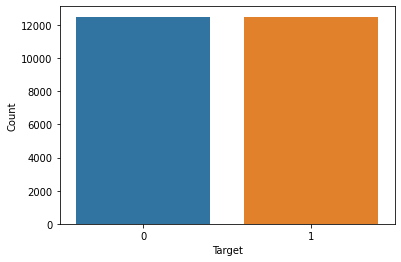

In [15]:
counts = df['target'].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Target')
plt.ylabel('Count')

In [16]:
from sklearn.utils import shuffle
df = shuffle(df)
df

,text,target
13066,Nathan Detroit runs illegal craps games for hi...,0
23981,This was the WORST movie I have ever seen! Mol...,0
8670,OK heres what I say: <br /><br />The movie was...,1
15734,hello boys and girls... this isn't your regula...,0
9082,"Lin McAdam (James Stewart) wins a rifle, a Win...",1
...,...,...
5648,A great film! Slow: YES.<br /><br />...but ori...,1
21085,I'll say it again: this movie was totally lame...,0
3394,"i just saw this film, i first saw it when i wa...",1
11097,This is a FUNNY film. It has all the usual Dis...,1


In [17]:
df.describe()

,target
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [18]:
df.isnull().sum()

text      0
target    0
dtype: int64

In [19]:
def clean_text(text):
    text = text.lower()                                  
    text =  re.sub(r'@\S+', '',text)                     
    text =  re.sub(r'http\S+', '',text)                  
    text =  re.sub(r'pic.\S+', '',text) 
    text =  re.sub(r"[^a-zA-Z+']", ' ',text)             
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ')      
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.tokenize.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')  
    text = " ".join([i for i in words if i not in stopwords and len(i)>2])
    text= re.sub("\s[\s]+", " ",text).strip()            
    return text

In [20]:
df['Text_cleaning'] = df.text.apply(clean_text)

In [21]:
X = df['Text_cleaning']
y = df['target']

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import  CountVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
h_read_x_test = X_test

In [25]:
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

text = df['Text_cleaning']
counter = counter_word(text)
num_words = len(counter)
max_len=1000

In [26]:
num_words

76806

In [27]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

In [28]:
X_train = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(X_train,maxlen=max_len, truncating="post")

In [29]:
X_test = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(X_test,maxlen=max_len, truncating="post")

In [30]:
from tensorflow.keras import regularizers

In [31]:
model = Sequential()
model.add(Embedding(num_words, 32,input_length=max_len))
model.add(LSTM(64,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l1_l2(0.01)))



In [32]:
from tensorflow.keras.optimizers import SGD,Adam

In [33]:
opt = Adam(learning_rate=0.0001)

In [34]:
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 32)          2457792   
_________________________________________________________________
lstm (LSTM)                  (None, 1000, 64)          24832     
_________________________________________________________________
dropout (Dropout)            (None, 1000, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 2,515,713
Trainable params: 2,515,713
Non-trainable params: 0
______________________________________________

In [36]:
history = model.fit(train_padded, y_train,batch_size=64, epochs=5, validation_data=(test_padded, y_test),verbose=1)

Epoch 1/5
313/313 [==============================] - 421s 1s/step - loss: 0.7041 - accuracy: 0.6453 - val_loss: 0.5271 - val_accuracy: 0.7892
Epoch 2/5
313/313 [==============================] - 447s 1s/step - loss: 0.4015 - accuracy: 0.8754 - val_loss: 0.3998 - val_accuracy: 0.8700
Epoch 3/5
313/313 [==============================] - 453s 1s/step - loss: 0.2898 - accuracy: 0.9259 - val_loss: 0.3857 - val_accuracy: 0.8784
Epoch 4/5
313/313 [==============================] - 466s 1s/step - loss: 0.2195 - accuracy: 0.9576 - val_loss: 0.4074 - val_accuracy: 0.8728
Epoch 5/5
313/313 [==============================] - 468s 1s/step - loss: 0.1805 - accuracy: 0.9717 - val_loss: 0.4069 - val_accuracy: 0.8786


In [37]:
def save(model):
    # Save the trained weights
    model.save_weights('model_weights.h5')

    # Save the model architecture
    with open('model_architecture.json', 'w') as f:
        f.write(model.to_json())

    # Save the tokenizer
    with open('tokenizer.json', 'w') as f:
        f.write(tokenizer.to_json())


In [38]:
save(model)

In [39]:
results = model.evaluate(test_padded, y_test, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.40688
Test Accuracy: 87.86%


In [40]:
y_pred = model.predict(test_padded)


In [41]:
y_test,y_pred

(24258    0
 15478    0
 1837     1
 20589    0
 7312     1
         ..
 18762    0
 728      1
 17455    0
 7068     1
 23676    0
 Name: target, Length: 5000, dtype: int64,
 array([[0.02749118],
        [0.23643184],
        [0.9737817 ],
        ...,
        [0.02867791],
        [0.41713867],
        [0.6552831 ]], dtype=float32))

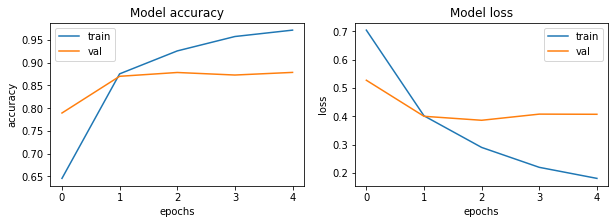

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val']) 

In [43]:
len(X_test),len(test_padded)

(5000, 5000)

In [44]:
h_read_x_test

24258    terrible dont want negative film stupid monkey...
15478    flipping channels late saturday night friends ...
1837     agree comment love realism many movies movies ...
20589    okay know millions americans believe rapture m...
7312     watched sky missed first half hour wonder true...
                               ...                        
18762    going say first given film thought going give ...
728      great barbara stanwyck film happened see night...
17455    adam sandler without doubt one idiotic films e...
7068     anyone know kind john drove looks like mid lat...
23676    garson kanin wrote directed look modern day la...
Name: Text_cleaning, Length: 5000, dtype: object

In [45]:
y_pred_reshaped = y_pred.reshape(-1)

In [56]:
df = pd.DataFrame({
    'Test_set': h_read_x_test,
    'Actual Values': y_test,
    'Predicted Values': y_pred_reshaped,
})

In [57]:
df

,Test_set,Actual Values,Predicted Values
24258,terrible dont want negative film stupid monkey...,0,0.027491
15478,flipping channels late saturday night friends ...,0,0.236432
1837,agree comment love realism many movies movies ...,1,0.973782
20589,okay know millions americans believe rapture m...,0,0.027304
7312,watched sky missed first half hour wonder true...,1,0.292472
...,...,...,...
18762,going say first given film thought going give ...,0,0.025793
728,great barbara stanwyck film happened see night...,1,0.975238
17455,adam sandler without doubt one idiotic films e...,0,0.028678
7068,anyone know kind john drove looks like mid lat...,1,0.417139


In [58]:
df['Predicted Values'] = df['Predicted Values'].apply(lambda x: 0 if x<0.65 else 1)
df

,Test_set,Actual Values,Predicted Values
24258,terrible dont want negative film stupid monkey...,0,0
15478,flipping channels late saturday night friends ...,0,0
1837,agree comment love realism many movies movies ...,1,1
20589,okay know millions americans believe rapture m...,0,0
7312,watched sky missed first half hour wonder true...,1,0
...,...,...,...
18762,going say first given film thought going give ...,0,0
728,great barbara stanwyck film happened see night...,1,1
17455,adam sandler without doubt one idiotic films e...,0,0
7068,anyone know kind john drove looks like mid lat...,1,0


In [59]:
df.to_csv("predicted_dataframe.csv")

In [73]:
TP = 2132
FP = 229
FN = 398
TN = 2241

In [76]:
precision = TP/(TP+FP)  
precision*100

90.30072003388395

In [77]:
recall = TP/(TP+FN)
recall*100

84.26877470355731

### F1-score is a measure of a model’s accuracy on a dataset


In [78]:
f1_score = (2 * precision * recall) / (precision + recall)

f1_score


0.8718053567777551